In [1]:
import spikeinterface.full as si

In [2]:
import probeinterface
from pathlib import Path

base_dir = Path('groundtruth')

probe = probeinterface.read_prb(base_dir / 'mea_256.prb')
from pathlib import Path
from spikeinterface.sortingcomponents.peak_detection import detect_peaks



In [3]:
from spikeinterface.sortingcomponents.peak_detection import detect_peaks

In [4]:
def plot_juxta_amplitude(juxta_filename, peaks):
    juxta_sig = np.memmap(juxta_filename, dtype='float32')
    
    med = np.median(juxta_sig)
    mad = np.median(np.abs(juxta_sig-med))*1.4826
    thresh = med + 8*mad
    
    fig, axs = plt.subplots(nrows=2)

    count, bins = np.histogram(peaks['amplitude'], bins=np.arange(np.min(peaks['amplitude']), 0,  0.5))
    ax = axs[0]
    ax.plot(bins[:-1], count)
    ax.axvline(-thresh, color='r', ls='--')
    ax.axvline(med, color='k', ls='-')
    for i in range(1,6):
        ax.axvspan(med - i * mad, med + i * mad, color='k', alpha=0.05)
    
    fig.suptitle('juxta peak amplitude')
    
    ax = axs[1]
    ax.plot(peaks['sample_index'], peaks['amplitude'], ls='None', marker='o')
    ax.axhline(-thresh, color='r', ls='--')
    for i in range(1,6):
        ax.axhspan(med - i * mad, med + i * mad, color='k', alpha=0.05)

/media/cure/Secondary/pierre/softwares/spikeinterface/src/spikeinterface/core/binaryrecordingextractor.py:77: UserWarning: `num_chan` is to be deprecated in version 0.100, please use `num_channels` instead
  warnings.warn("`num_chan` is to be deprecated in version 0.100, please use `num_channels` instead")


detect peaks using by_channel:   0%|          | 0/300 [00:00<?, ?it/s]

detect peaks using by_channel:   0%|          | 0/202 [00:00<?, ?it/s]

detect peaks using by_channel:   0%|          | 0/300 [00:00<?, ?it/s]

detect peaks using by_channel:   0%|          | 0/300 [00:00<?, ?it/s]

detect peaks using by_channel:   0%|          | 0/180 [00:00<?, ?it/s]

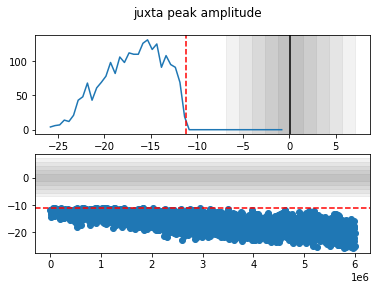

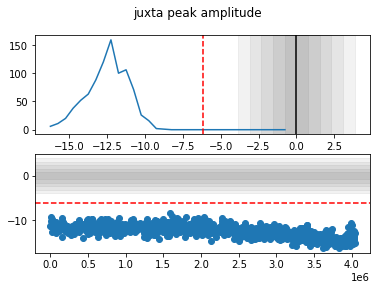

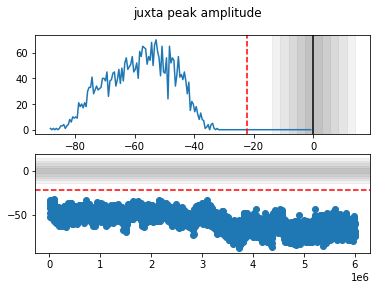

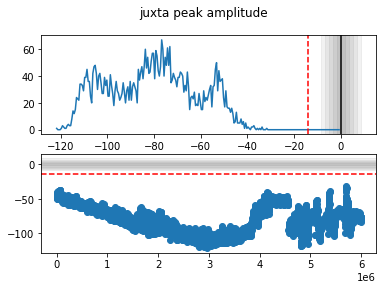

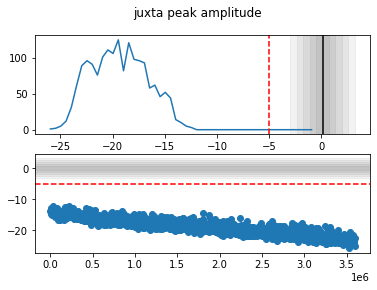

In [5]:
import os
recordings = {}
juxta = {}
peaks = {}
import numpy as np
import pylab as plt

for folder in os.listdir(base_dir / 'recordings'):
    file = base_dir / 'recordings' / folder / folder
    recording = si.read_mcsraw(str(file) + '.raw')
    recording.annotate(is_filtered=True)
    recording = recording.set_probegroup(probe)
    recordings[folder] = recording
    juxta[folder] = si.read_binary(str(file) + '.juxta.raw', sampling_frequency=20000, num_chan=1, dtype='float32')
    peaks[folder] = detect_peaks(juxta[folder], exclude_sweep_ms=2, detect_threshold=8)
    plot_juxta_amplitude(str(file) + '.juxta.raw', peaks[folder])

In [6]:
waveforms = {}
for folder in os.listdir(base_dir / 'recordings'):
    file = base_dir / 'waveforms' / folder
    times = peaks[folder]['sample_index']
    sorting = si.NumpySorting.from_times_labels(times, np.zeros(len(times), dtype=int), sampling_frequency=20000)
    waveforms[folder] = si.extract_waveforms(recordings[folder], sorting, ms_before=2, ms_after=2, mode='memory', n_jobs=-1, overwrite=True, chunk_memory="10M")

extract waveforms shared_memory multi buffer:   0%|          | 0/303 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/303 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/204 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/204 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/303 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/303 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/303 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/303 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/182 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/182 [00:00<?, ?it/s]

In [7]:
channel_positions = recordings['20160415_patch2'].get_channel_locations()
#real_positions = {'20160426_patch3' : channel_positions[226] + [0, -10],
#                  '20170726_patch1' : (0.9*channel_positions[30] + 0.1*channel_positions[3] + [5, 0]),
#                  '20170728_patch2' : channel_positions[118] + [0, 5],
#                  '20160426_patch2' : channel_positions[200] + [-15, -15], 
#                  '20160415_patch2' : (channel_positions[69] + channel_positions[33])/2.}

real_positions = {'20160426_patch3' : channel_positions[226] + [2, -5],
                  '20170726_patch1' : channel_positions[30] + [6,6],
                  '20170728_patch2' : channel_positions[118] + [-2,9],
                  '20160426_patch2' : channel_positions[200] + [-18, -12], 
                  '20160415_patch2' : channel_positions[69] +  [3,-15]}

In [19]:
%matplotlib inline

unit_positions = {}
spikes_positions = {}

import matplotlib.image as mpimg

for folder in  os.listdir(base_dir / 'recordings'):
    unit_positions[folder] = {}
    spikes_positions[folder] = {}
    for method in ['center_of_mass', 'monopolar_triangulation', 'grid_convolution']:
        if method == 'center_of_mass':
            for feature in ['ptp', 'energy', 'peak_voltage']:
                title = f'CoM ({feature})'
                params = {'feature' : feature}

                unit_positions[folder][title] = si.compute_unit_locations(waveforms[folder], method=method, 
                                                            **params)
                spikes_positions[folder][title] = si.compute_spike_locations(waveforms[folder], method=method, 
                                                                    method_kwargs=params, n_jobs=-1,
                                                                    spike_retriver_kwargs={'channel_from_template' : False}, 
                                                                    chunk_memory="10M", outputs='by_unit')
        elif method == 'monopolar_triangulation':
            for feature in ['ptp', 'energy', 'peak_voltage']:
                title = f'Monopolar ({feature})'
                params = {'enforce_decrease': True, 'feature' : feature}
                unit_positions[folder][title] = si.compute_unit_locations(waveforms[folder], method=method, 
                                                            **params)
                spikes_positions[folder][title] = si.compute_spike_locations(waveforms[folder], method=method, 
                                                                    method_kwargs=params, n_jobs=-1,
                                                                    spike_retriver_kwargs={'channel_from_template' : False}, 
                                                                    chunk_memory="10M", outputs='by_unit')
        elif method == 'grid_convolution':
            title = f'Grid'
            params = {}
    
            from spikeinterface.core.node_pipeline import SpikeRetriever
            from spikeinterface.core.template_tools import get_template_extremum_channel
            extremum_channel_inds = get_template_extremum_channel(waveforms[folder], peak_sign="neg", outputs="index")
            spike_retriever = SpikeRetriever(,
                        waveforms[folder].recording, waveforms[folder].sorting, extremum_channel_inds=extremum_channel_inds
            )
            #prototype = get_prototype_spike(waveforms[folder].recording, spike_retriever.peaks, 2, 2)\n",
            #params['prototype'] = -prototype                       \n",
            unit_positions[folder][title] = si.compute_unit_locations(waveforms[folder], method=method,
                                                                    **params)\n
    
                #prototype = get_prototype_spike(waveforms[folder].recording, spike_retriever.peaks, 0.5, 0.5)\n",
                #params['prototype'] = prototype\n",
                spikes_positions[folder][title] = si.compute_spike_locations(waveforms[folder], method=method, \n",
                                                                            method_kwargs=params, n_jobs=-1,\n",
                                                                            spike_retriver_kwargs={'channel_from_template' : False}, \n",
                                                                            chunk_memory=\"10M\", outputs='by_unit')"

localize peaks using center_of_mass:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/303 [00:00<?, ?it/s]

pipeline:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using grid_convolution:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/204 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/204 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/204 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/204 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/204 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/204 [00:00<?, ?it/s]

pipeline:   0%|          | 0/204 [00:00<?, ?it/s]

localize peaks using grid_convolution:   0%|          | 0/204 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/303 [00:00<?, ?it/s]

pipeline:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using grid_convolution:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/303 [00:00<?, ?it/s]

pipeline:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using grid_convolution:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/182 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/182 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/182 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/182 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/182 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/182 [00:00<?, ?it/s]

pipeline:   0%|          | 0/182 [00:00<?, ?it/s]

localize peaks using grid_convolution:   0%|          | 0/182 [00:00<?, ?it/s]

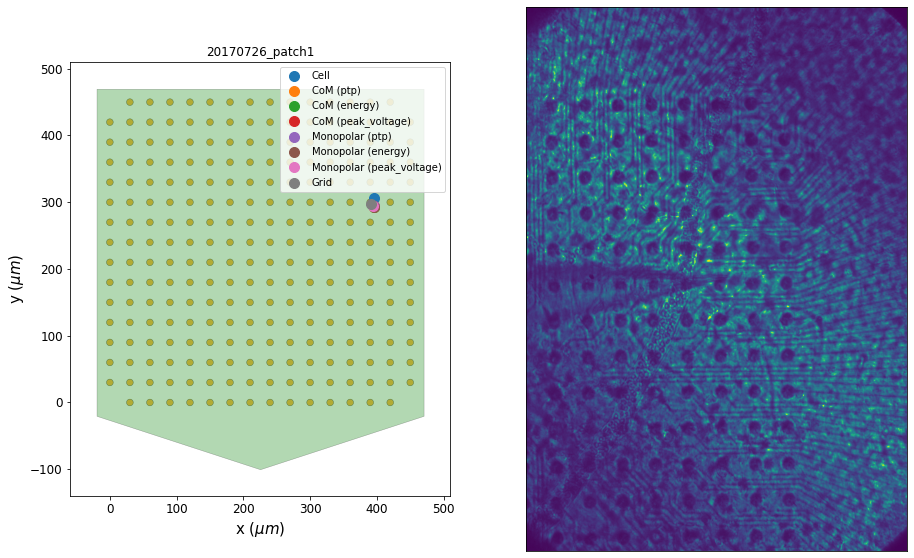

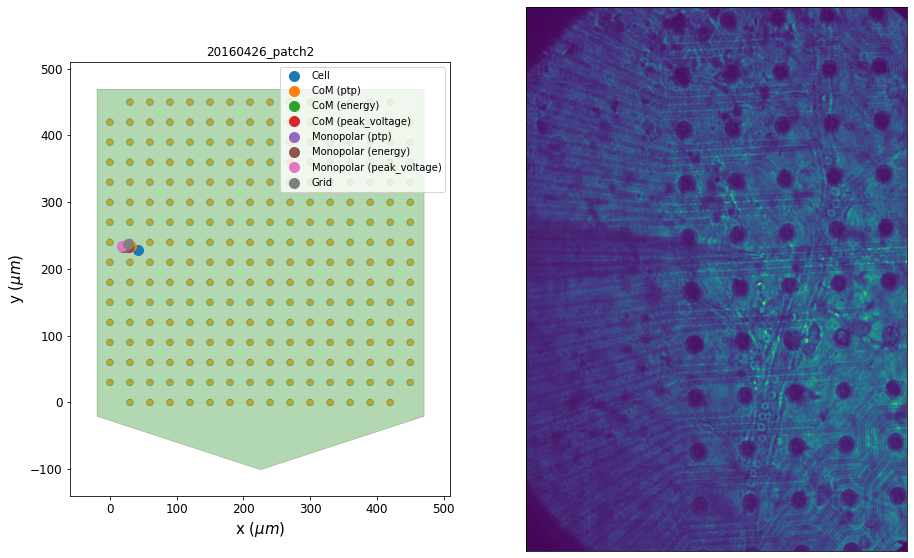

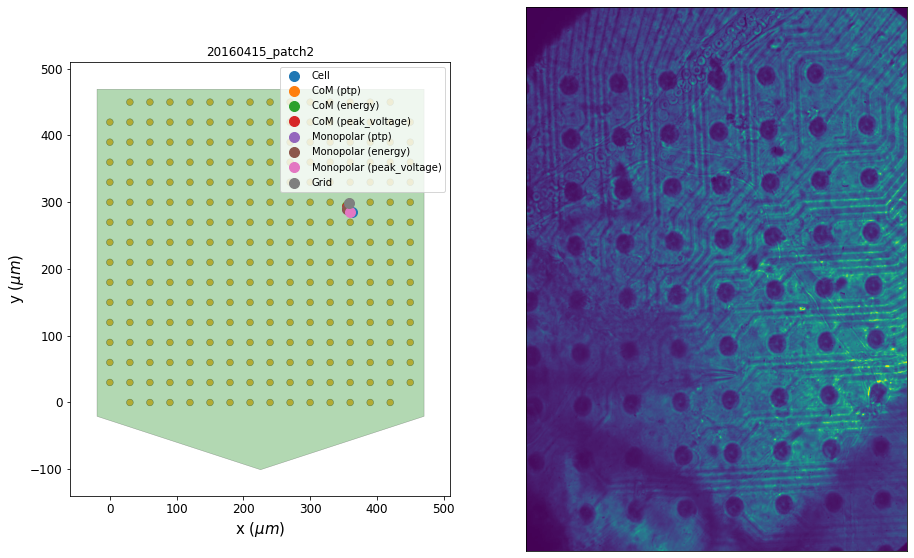

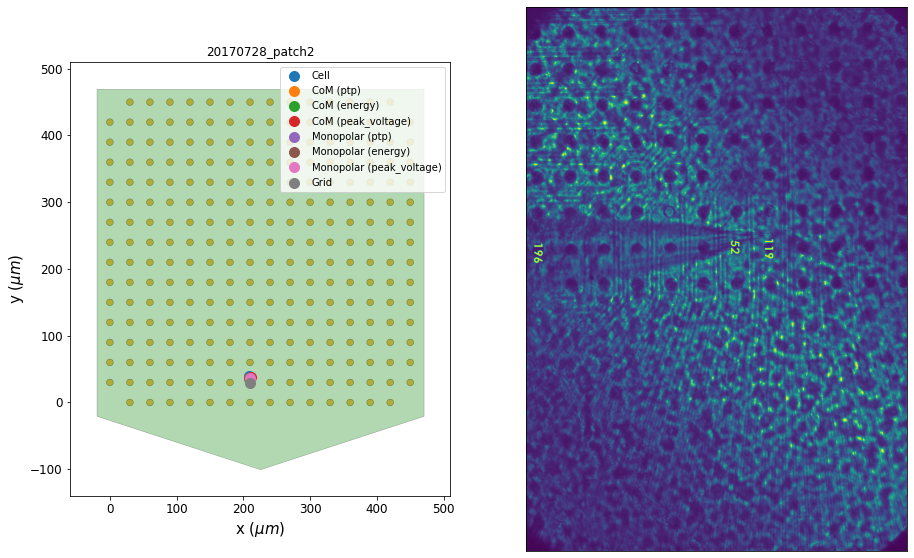

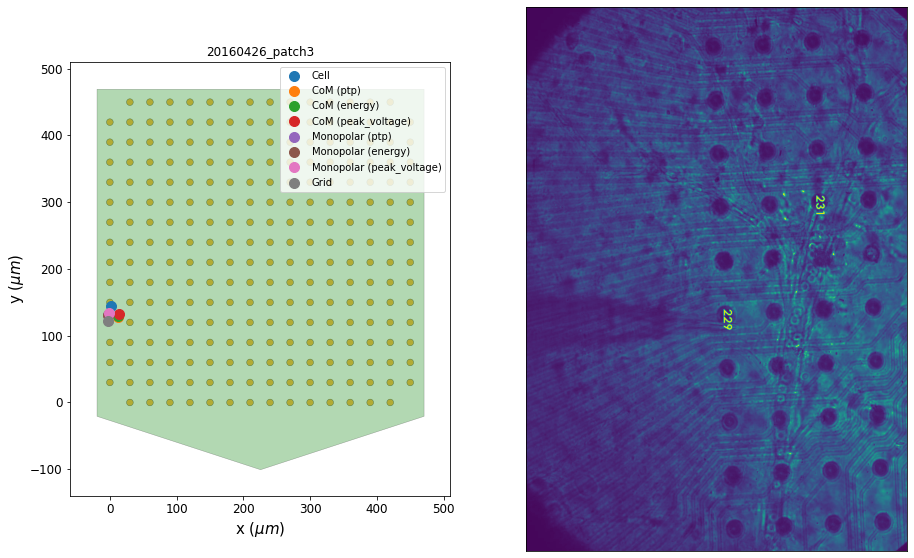

In [20]:
%matplotlib inline

import matplotlib.image as mpimg

for folder in  os.listdir(base_dir / 'recordings'):
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    
    si.plot_probe_map(recording, ax=axes[0])
    
    #count = 0
    #for key, value in spikes_positions[folder].items():
    #    axes[0].scatter(value[0][0.0]['x'], value[0][0.0]['y'], alpha=0.01, c=f'C{count}')
    #    count += 1
        
    axes[0].scatter([real_positions[folder][0]], [real_positions[folder][1]], s=100, label='Cell')
    for key, value in unit_positions[folder].items(): 
        axes[0].scatter([value[0][0]], [value[0][1]], s=100, label=key)
    
    axes[0].legend()
    
    file = base_dir / 'recordings' / folder / folder
    img = mpimg.imread(f'{file}.jpg')
    imgplot = axes[1].imshow(img, aspect='auto')
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[0].set_title(folder)

In [21]:
def _simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()


In [22]:
res_units = {}
res_spikes = {}
for folder in real_positions.keys():
    res_spikes[folder] = {}
    res_units[folder] = {}
    for key in unit_positions[folder].keys():
        res_units[folder][key] = np.linalg.norm(real_positions[folder] - unit_positions[folder][key][0, :2])
        
        data = spikes_positions[folder][key][0][0.0]
        errors = np.sqrt((data['x'] - real_positions[folder][0])**2 + (data['y'] - real_positions[folder][1])**2)
        res_spikes[folder][key] = list(errors)


In [23]:
colors = {}

import matplotlib as mpl

cmap = mpl.cm.tab20c
norm = mpl.colors.Normalize(vmin=0, vmax=1)

for value, key in zip([0,0.05,0.1,0.4,0.45,0.5,0.8], res_units['20160426_patch3'].keys()):    
    colors[key] = mpl.cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba(value)


/tmp/ipykernel_2225159/2196889925.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([value[0][0]], [value[0][1]], s=100, label=key, c=colors[key])


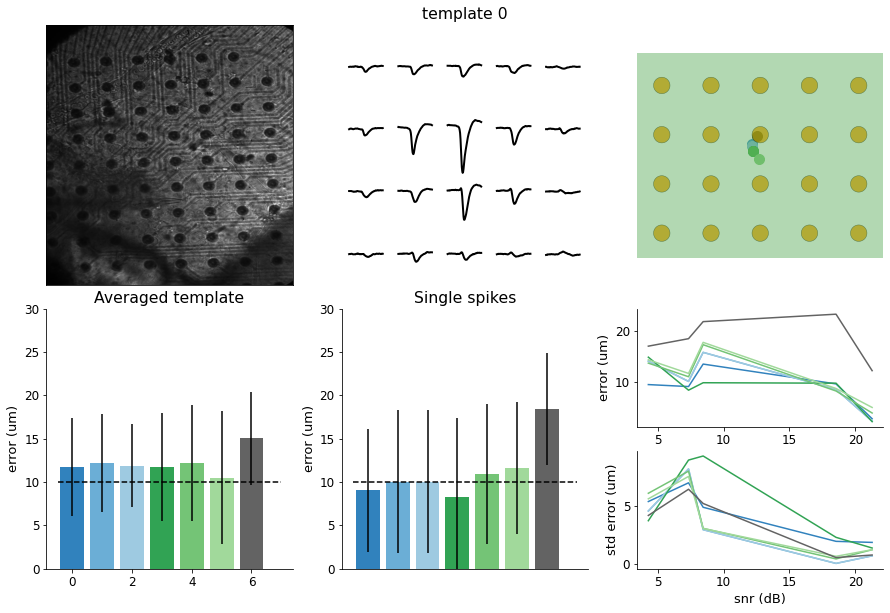

In [26]:
fig = plt.figure(figsize=(15, 10))

gs = fig.add_gridspec(4, 3)

plt.rc('font', size=13)
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

file = base_dir / 'recordings' / '20160415_patch2' / '20160415_patch2'
img = mpimg.imread(f'{file}.jpg')

ax = fig.add_subplot(gs[0:2, 0])

imgplot = ax.imshow(img, aspect='auto', cmap='gray')
ax.set_xticks([])
ax.set_yticks([])

folder = '20160415_patch2'
ax = fig.add_subplot(gs[0:2, 2])
#axes[0, 2].scatter([real_positions[folder][0]], [real_positions[folder][1]], s=100, label='Cell')
for key, value in unit_positions[folder].items(): 
    ax.scatter([value[0][0]], [value[0][1]], s=100, label=key, c=colors[key])
si.plot_probe_map(recording, ax=ax)

_simpleaxis(ax)
ax.set_xlim(285, 435)
ax.set_ylim(225, 350)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

count = 0

all_units = {}
for folder, data in res_units.items():
    for method, value in data.items():
        if method not in all_units:
            all_units[method] = [value]
        else:
            all_units[method] += [value]

ax = fig.add_subplot(gs[2:4, 0])
for key, value in all_units.items():
    ax.bar([count], np.array(value).mean(), yerr=np.array(value).std(), facecolor=colors[key])
    count += 1
ax.set_ylabel('error (um)')
ax.set_title('Averaged template')
ax.set_ylim(0, 30)
#axes[1, 0].set_yscale('log')
ax.plot([-0.5, len(all_units.keys())], [10, 10], 'k--')
    
_simpleaxis(ax)
ax = fig.add_subplot(gs[0:2, 1])
si.plot_unit_templates(waveforms['20160415_patch2'], ax=ax, same_axis=True, unit_colors={0 : 'k'}, plot_legend=False)
ax.set_xlim(285, 435)
ax.set_ylim(225, 350)
_simpleaxis(ax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

    
_simpleaxis(ax)


ax = fig.add_subplot(gs[2:4, 1])
#axes[1, 0].set_xticks(np.arange(len(res_unit.keys())), res_unit.keys(), rotation=45)


all_spikes = {}
for folder, data in res_spikes.items():
    for method, value in data.items():
        if method not in all_spikes:
            all_spikes[method] = value
        else:
            all_spikes[method] += value

count = 0
for key, value in all_spikes.items():
    ax.bar([count], np.array(value).mean(), yerr=np.array(value).std(), facecolor=colors[key])
    count += 1

#axes[1, 1].set_yscale('log')
_simpleaxis(ax)
#axes[1, 1].set_xticks(np.arange(len(res_unit.keys())), res_unit.keys(), rotation=45)
ax.set_ylabel('error (um)')
ax.set_title('Single spikes')
ax.set_ylim(0, 30)
ax.set_xticks([], [])
ax.plot([-0.5, len(all_units.keys())], [10, 10], 'k--')

res = []
for folder in real_positions.keys():
    res += [si.compute_snrs(waveforms[folder])[0.0]]

idx = np.argsort(res)
res = np.array(res)



all_means = {}
all_stds = {}

for key in res_spikes.keys():
    for method in res_spikes[key].keys():
        if method in all_means:
            all_means[method] += [np.mean(res_spikes[key][method])]
            all_stds[method] += [np.std(res_spikes[key][method])]
        else:
            all_means[method] = [np.mean(res_spikes[key][method])]
            all_stds[method] = [np.std(res_spikes[key][method])]

            

ax_1 = fig.add_subplot(gs[2, 2])
ax_2 = fig.add_subplot(gs[3, 2])
for key in all_means.keys():
    all_means[key] = np.array(all_means[key])
    all_stds[key] = np.array(all_stds[key])
    ax_1.plot(res[idx], all_means[key][idx], label=key, c=colors[key]) 
    ax_2.plot(res[idx], all_stds[key][idx], label=key, c=colors[key]) 
_simpleaxis(ax_1)
_simpleaxis(ax_2)

#ax_1.set_xlabel('snr (dB)')
ax_1.set_ylabel('error (um)')

ax_2.set_xlabel('snr (dB)')
ax_2.set_ylabel('std error (um)')

#ax.legend()
plt.savefig('gt.pdf')
